In [1]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nrelpy.atb import ATBe

## Technology Data and Costs

As a first pass, we can use data curated by the PyPSA team for Europe in units of &euro; (later, we can convert these to dollars or use data from NREL).

In [2]:
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

In [3]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["CCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

In [4]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [5]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

In [7]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [8]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

## Retrieve Time Series Data

In [9]:
pjm_load = pd.read_csv("../data/pjm_demand.csv", usecols=['Interval End','CE'], parse_dates=True, index_col='Interval End')

In [10]:
pjm_load.head(2)

,CE
Interval End,
2019-01-01 00:00:00+00:00,11593.0
2019-01-01 01:00:00+00:00,11258.0


In [11]:
miso_load = pd.read_csv('../data/miso_demand.csv', usecols=['Interval End','0004'], parse_dates=True, index_col='Interval End')
miso_load.head(2)

,0004
Interval End,
2019-01-01 00:00:00+00:00,5406.0
2019-01-01 01:00:00+00:00,5289.0


In [12]:
load_year = 2022

pjm_2022 = pjm_load[pjm_load.index.year == load_year]
miso_2022 = miso_load[miso_load.index.year == load_year]

Update the resolution for simplicity

In [13]:
resolution = 4
pjm_2022 = pjm_2022.resample(f"{resolution}h").mean()
miso_2022 = miso_2022.resample(f"{resolution}h").mean()

## Capacity Expansion Model

### Model Initialization

In [14]:
n = pypsa.Network()

Add two buses -- PJM ComEd and Miso Zone 4

In [15]:
n.add("Bus", "0004")
n.add("Bus", "CE")

In [16]:
n.buses.index

Index(['0004', 'CE'], dtype='object', name='Bus')

In [17]:
n.set_snapshots(pjm_2022.index)

In [18]:
n.snapshots

DatetimeIndex(['2022-01-01 00:00:00+00:00', '2022-01-01 04:00:00+00:00',
               '2022-01-01 08:00:00+00:00', '2022-01-01 12:00:00+00:00',
               '2022-01-01 16:00:00+00:00', '2022-01-01 20:00:00+00:00',
               '2022-01-02 00:00:00+00:00', '2022-01-02 04:00:00+00:00',
               '2022-01-02 08:00:00+00:00', '2022-01-02 12:00:00+00:00',
               ...
               '2022-12-30 08:00:00+00:00', '2022-12-30 12:00:00+00:00',
               '2022-12-30 16:00:00+00:00', '2022-12-30 20:00:00+00:00',
               '2022-12-31 00:00:00+00:00', '2022-12-31 04:00:00+00:00',
               '2022-12-31 08:00:00+00:00', '2022-12-31 12:00:00+00:00',
               '2022-12-31 16:00:00+00:00', '2022-12-31 20:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='snapshot', length=2190, freq='4h')

In [19]:
n.snapshot_weightings.loc[:,:] = resolution  # how many hours each timeslice represents, based on the temporal resolution

In [20]:
carriers = [
    "onwind",
    # "offwind",
    "nuclear",
    "solar",
    "OCGT",
    # "CCGT",
    "hydrogen storage underground",
    "battery storage",
]

colors = {"onwind":'dodgerblue',
          "offwind":"aquamarine",
          "nuclear":"green",
          "solar":"gold",
          "OCGT":"indianred",
          "CCGT":"orange",
          "hydrogen storage underground":"magenta",
          "battery storage":"yellowgreen"}

n.madd(
    "Carrier",
    carriers,
    color=[colors[c] for c in carriers],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

Index(['onwind', 'nuclear', 'solar', 'OCGT', 'hydrogen storage underground',
       'battery storage'],
      dtype='object')

Add the load to the buses

In [21]:
n.add(
    "Load",
    "pjm_load",
    bus='CE',
    p_set = pjm_2022['CE']
)

n.add(
    "Load",
    "miso_load",
    bus='0004',
    p_set = miso_2022['0004']
)

<Axes: xlabel='snapshot', ylabel='MW'>

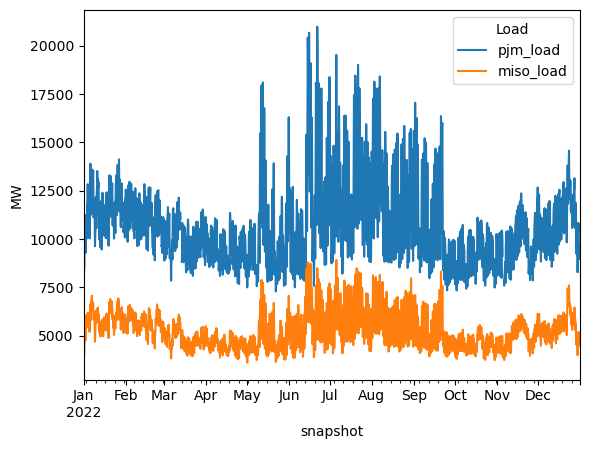

In [22]:
n.loads_t.p_set.plot(ylabel='MW')

### Adding generators to the model

In [23]:
n.madd?

Signature: n.madd(class_name, names, suffix='', **kwargs)
Docstring:
Add multiple components to the network, along with their attributes.

Make sure when adding static attributes as pandas Series that they are indexed
by names. Make sure when adding time-varying attributes as pandas DataFrames that
their index is a superset of network.snapshots and their columns are a
subset of names.

Any attributes which are not specified will be given the default
value from :doc:`components`.

Parameters
----------
class_name : string
    Component class name in ("Bus", "Generator", "Load", "StorageUnit",
    "Store", "ShuntImpedance", "Line", "Transformer", "Link").
names : list-like or pandas.Index
    Component names
suffix : string, default ''
    All components are named after names with this added suffix. It
    is assumed that all Series and DataFrames are indexed by the original names.
kwargs
    Component attributes, e.g. x=[0.1, 0.2], can be list, pandas.Series
    of pandas.DataFrame for 

In [24]:
buses = ['CE','0004']
n.madd(
    "Generator",
    buses,
    suffix=' OCGT',
    bus=["CE", '0004'],
    carrier="OCGT",
    capital_cost=costs.at["OCGT", "capital_cost"],
    marginal_cost=costs.at["OCGT", "marginal_cost"],
    efficiency=costs.at["OCGT", "efficiency"],
    p_nom_extendable=True,
)

Index(['CE OCGT', '0004 OCGT'], dtype='object')

In [25]:
miso_2022.index

DatetimeIndex(['2022-01-01 00:00:00+00:00', '2022-01-01 04:00:00+00:00',
               '2022-01-01 08:00:00+00:00', '2022-01-01 12:00:00+00:00',
               '2022-01-01 16:00:00+00:00', '2022-01-01 20:00:00+00:00',
               '2022-01-02 00:00:00+00:00', '2022-01-02 04:00:00+00:00',
               '2022-01-02 08:00:00+00:00', '2022-01-02 12:00:00+00:00',
               ...
               '2022-12-30 08:00:00+00:00', '2022-12-30 12:00:00+00:00',
               '2022-12-30 16:00:00+00:00', '2022-12-30 20:00:00+00:00',
               '2022-12-31 00:00:00+00:00', '2022-12-31 04:00:00+00:00',
               '2022-12-31 08:00:00+00:00', '2022-12-31 12:00:00+00:00',
               '2022-12-31 16:00:00+00:00', '2022-12-31 20:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Interval End', length=2190, freq='4h')

In [26]:
n.snapshots

DatetimeIndex(['2022-01-01 00:00:00+00:00', '2022-01-01 04:00:00+00:00',
               '2022-01-01 08:00:00+00:00', '2022-01-01 12:00:00+00:00',
               '2022-01-01 16:00:00+00:00', '2022-01-01 20:00:00+00:00',
               '2022-01-02 00:00:00+00:00', '2022-01-02 04:00:00+00:00',
               '2022-01-02 08:00:00+00:00', '2022-01-02 12:00:00+00:00',
               ...
               '2022-12-30 08:00:00+00:00', '2022-12-30 12:00:00+00:00',
               '2022-12-30 16:00:00+00:00', '2022-12-30 20:00:00+00:00',
               '2022-12-31 00:00:00+00:00', '2022-12-31 04:00:00+00:00',
               '2022-12-31 08:00:00+00:00', '2022-12-31 12:00:00+00:00',
               '2022-12-31 16:00:00+00:00', '2022-12-31 20:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='snapshot', length=2190, freq='4h')

In [27]:
n

PyPSA Network
Components:
 - Bus: 2
 - Carrier: 6
 - Generator: 2
 - Load: 2
Snapshots: 2190

In [28]:
n.loads_t

{'p_set': Load                       pjm_load  miso_load
 snapshot                                      
 2022-01-01 00:00:00+00:00  10221.00    4720.00
 2022-01-01 04:00:00+00:00   9156.75    4259.75
 2022-01-01 08:00:00+00:00   8376.00    3993.50
 2022-01-01 12:00:00+00:00   8713.00    4258.25
 2022-01-01 16:00:00+00:00   9598.00    4814.75
 ...                             ...        ...
 2022-12-31 04:00:00+00:00   9765.50    4787.25
 2022-12-31 08:00:00+00:00   8957.25    4491.75
 2022-12-31 12:00:00+00:00   9507.25    4774.00
 2022-12-31 16:00:00+00:00   9693.75    4851.75
 2022-12-31 20:00:00+00:00   9786.00    4756.75
 
 [2190 rows x 2 columns],
 'q_set': Empty DataFrame
 Columns: []
 Index: [2022-01-01 00:00:00+00:00, 2022-01-01 04:00:00+00:00, 2022-01-01 08:00:00+00:00, 2022-01-01 12:00:00+00:00, 2022-01-01 16:00:00+00:00, 2022-01-01 20:00:00+00:00, 2022-01-02 00:00:00+00:00, 2022-01-02 04:00:00+00:00, 2022-01-02 08:00:00+00:00, 2022-01-02 12:00:00+00:00, 2022-01-02 16:00:00+0

In [35]:
n.optimize(solver_name='highs')

c:\Users\sdotson\AppData\Local\miniforge3\envs\pypsa-illinois\lib\site-packages\linopy\common.py:133: UserWarning:

coords for dimension(s) ['snapshot'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.06s
INFO:linopy.solvers:Log file at C:\Users\sdotson\AppData\Local\Temp\highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 4382 primals, 13142 duals
Objective: 1.06e+10
Solver model: available
Solver message: optimal

c:\Users\sdotson\AppData\Local\miniforge3\envs\pypsa-illinois\lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. T

('ok', 'optimal')

In [36]:
n.generators_t.p

Generator,CE OCGT,0004 OCGT
snapshot,,
2022-01-01 00:00:00+00:00,10221.00,4720.00
2022-01-01 04:00:00+00:00,9156.75,4259.75
2022-01-01 08:00:00+00:00,8376.00,3993.50
2022-01-01 12:00:00+00:00,8713.00,4258.25
2022-01-01 16:00:00+00:00,9598.00,4814.75
...,...,...
2022-12-31 04:00:00+00:00,9765.50,4787.25
2022-12-31 08:00:00+00:00,8957.25,4491.75
2022-12-31 12:00:00+00:00,9507.25,4774.00


In [39]:
def plot_dispatch(n, time="2022-07"):
    p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)

    if not n.storage_units.empty:
        sto = n.storage_units_t.p.T.groupby(n.storage_units.carrier).sum().T.div(1e3)
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)

    fig, ax = plt.subplots(figsize=(6, 3))

    color = p_by_carrier.columns.map(n.carriers.color)

    p_by_carrier.where(p_by_carrier > 0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=color,
    )

    charge = p_by_carrier.where(p_by_carrier < 0).dropna(how="all", axis=1).loc[time]

    if not charge.empty:
        charge.plot.area(
            ax=ax,
            linewidth=0,
            color=charge.columns.map(n.carriers.color),
        )

    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c="k")

    plt.legend(loc=(1.05, 0))
    ax.set_ylabel("GW")
    ax.set_ylim(-200, 200)

C:\Users\sdotson\AppData\Local\Temp\ipykernel_19016\2439899802.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



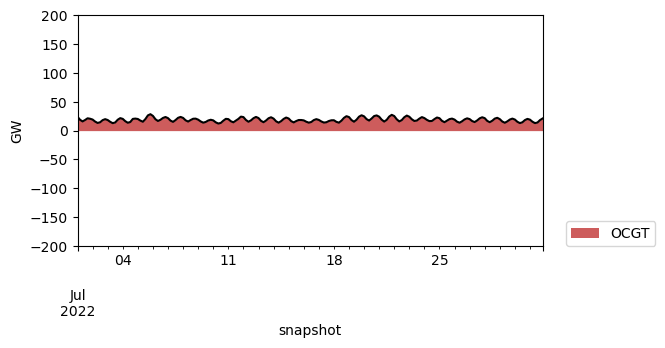

In [40]:
plot_dispatch(n)